<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
# это чтобы в диаграме служебные строки не лезли
import matplotlib.pyplot as plt

## Подготовка данных

Сначала прочитаем данные и посмотрим на первые 10 записей

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Видно, что в колонке Tenure меньше Non-Null значений, чем в других колонках. Проверим все колонки на null-значения.

In [4]:
data.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Tenure - количество лет, которое пользователь является клиентом банка.

Т.к. данных у нас мало, то удалять мы их не будем.

Заменим null значение на медиану, чтобы не изменять структуру распределения признака.

In [5]:
median_tenure = data['Tenure'].median()
data['Tenure'] = data['Tenure'].fillna(median_tenure)
print('Медианное значение срока клиентских отношений:', median_tenure)

Медианное значение срока клиентских отношений: 5.0


Колонки 'RowNumber', 'CustomerId', 'Surname' не являются признаками для предсказания, т.к. в каждой строчке номер будет уникальный.
Surname (Фамилия) теоретически может повторятся, но оно не должно влиять на принятие решения.
Удалим эти колонки из датасета для обучения.

In [6]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Преобразуем категориальные признаки в численные методом прямого кодирования.

In [7]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


In [8]:
data_ohe.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
5,645,44,8.0,113755.78,2,1,0,149756.71,1,0,1,1
6,822,50,7.0,0.00,2,1,1,10062.80,0,0,0,1
7,376,29,4.0,115046.74,4,1,0,119346.88,1,1,0,0
8,501,44,4.0,142051.07,2,0,1,74940.50,0,0,0,1
9,684,27,2.0,134603.88,1,1,1,71725.73,0,0,0,1


Выделим из исходного набора данных признаки для обучения и целевой признак в переменные features и target соответтсвенно.
Разделим наборы данных на выборки для обучения, валидации и тестирования.

In [9]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

#отделим 60% данных для обучающей выборки
features_train, features_valid_and_test, target_train, target_valid_and_test = train_test_split(
    features, target, train_size=0.6, random_state=12345)

#разделим валидационную и тестовую выборку пополам
features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid_and_test, target_valid_and_test, train_size=0.5, random_state=12345)

In [10]:
print('Тренировочная:', features_train.shape)
print('Валидационная:', features_valid.shape)
print('Тестовая:', features_test.shape)

Тренировочная: (6000, 11)
Валидационная: (2000, 11)
Тестовая: (2000, 11)


Выборки разбиты верно.

По данным было видно, что у числовых признаков разный масштаб. Поэтому их нужно масштабировать.

In [11]:
pd.options.mode.chained_assignment = None #чтобы выключить предупреждение
scaler = StandardScaler()
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.082277,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.082277,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.737696,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.354288,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-1.101690,1.140475,-0.891560,0,0,1.524268,1,0,0
8741,-0.315586,-1.512032,1.082277,-1.233163,0.830152,1,1,0.552345,0,1,0
7461,-0.585591,-0.657902,-0.373701,-1.233163,0.830152,0,1,0.814122,0,1,1
5106,-0.544052,-0.657902,-1.465685,0.031212,-0.891560,1,0,-0.608723,0,0,0
6130,-0.211738,-0.373192,-1.101690,1.190787,0.830152,0,0,-0.602263,1,0,0
4955,1.273291,-0.562998,-0.009707,0.111168,0.830152,1,0,0.508214,1,0,1


In [12]:
features_valid.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7041,-2.226392,-0.088482,-1.101690,-1.233163,0.830152,1,0,0.647083,0,0,1
5709,-0.087120,0.006422,1.446272,-1.233163,-0.891560,1,0,-1.658410,0,0,0
7117,-0.917905,-0.752805,-0.009707,0.722307,-0.891560,1,1,-1.369334,0,1,1
7775,-0.253277,0.101325,1.810266,-1.233163,0.830152,1,0,0.075086,0,1,1
8735,0.785204,-0.847708,1.810266,0.615625,-0.891560,0,1,-1.070919,0,0,1
9182,-0.575206,-1.037515,-1.829679,1.064325,-0.891560,1,0,0.480366,0,0,0
2493,1.345984,-1.512032,1.810266,0.345431,-0.891560,1,1,0.746282,0,1,1
1819,0.639817,0.575842,1.082277,1.196249,0.830152,0,1,0.699553,0,1,1
2980,2.052152,0.196229,-0.737696,0.375912,0.830152,1,0,-0.490439,0,1,0
7830,-0.595976,-0.562998,1.446272,-1.233163,0.830152,1,1,-1.005360,0,0,0


In [13]:
features_test.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8532,-0.699824,-0.373192,-1.101690,-1.233163,0.830152,1,0,-0.015173,0,0,0
5799,-0.284431,0.575842,-0.737696,-1.233163,-0.891560,1,1,1.471724,0,0,0
5511,0.151731,-0.657902,-1.829679,0.438711,-0.891560,1,0,-1.367107,1,0,1
7365,-0.876366,-0.278288,1.810266,1.239884,-0.891560,1,1,-0.786517,0,1,0
7367,-0.481743,0.291132,1.810266,-1.233163,0.830152,1,0,1.358533,0,1,1
4120,0.141346,-1.701839,-1.465685,0.728192,0.830152,1,1,0.005562,1,0,0
2488,-0.076735,-1.701839,-1.465685,-1.233163,0.830152,0,0,-1.225690,0,1,0
8271,-1.779845,-0.183385,1.082277,1.218843,0.830152,1,1,1.309064,0,0,1
8653,-0.118274,1.714682,-0.009707,-1.233163,0.830152,1,1,0.397508,0,0,1
3452,1.086364,1.714682,-0.737696,0.200967,-0.891560,1,1,-0.802184,0,0,1


Теперь можно приступать к исследованию.

**Резюме**

Я подготовил исходную выборку для анализа:
- заполнил null в колонке Tenure медианным значением признака, чтобы увеличить объем выборки для исследования
- убрал из датасета признаки, непригодные для анализа: 'RowNumber', 'CustomerId', 'Surname'
- преобразовал категориальные признаки в численные методом прямого кодирования
- привел все признаки к одному масштабу
- разлелил выборку на 3 набора: обучающий, валидационный и тестовый

## Исследование задачи

Я буду исследовать различные модели: логистическую регрессию, решающее дерево и случайный лес.<br/>
Порядок исследования всегда совпадает, поэтому рассчет характеристик качества модели выведу в отдельную функцию.

In [14]:
def model_analysis(model, features_train, target_train, features_valid, target_valid):
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    return {
        'Полнота': recall_score(target_valid, predictions_valid),
        'Точность': precision_score(target_valid, predictions_valid),
        'F1 метрика': f1_score(target_valid, predictions_valid),
        'AUC ROC': roc_auc_score(target_valid, probabilities_one_valid)
    }

Для случайного леса нужно подбирать параметры max_depth и n_estimators.
И т.к. в течение всего исследования мы будем менять обучающие выборки, оптимальные параметры модели случайного леса под разные выборки могут отличаться. Выделим алгоритм поиска параметров модели случайного леса в отдельную функцию.<br/>
Добавим сразу параметр class_weight, т.к. позже будем исследовать проблемы дисбаланса. По умолчанию параметр None.

In [15]:
def get_optimal_random_forest_classifier_params(features_train, target_train, features_valid, target_valid, class_weight=None):
    best_f1 = 0
    best_est = 0
    best_depth = 0
    best_criterion = None
    best_min_samples_leaf = 0
    for min_samples_leaf in range(1, 6, 1):
        for criterion in "gini", "entropy":
            for est in range(10, 71, 10):
                for depth in range (1, 14, 2):
                    model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, criterion=criterion, min_samples_leaf=min_samples_leaf, class_weight=class_weight)
                    model.fit(features_train, target_train)
                    predictions_valid = model.predict(features_valid)
                    f1 = f1_score(target_valid, predictions_valid) 
                    if (f1 > best_f1):
                        best_f1 = f1
                        best_est = est
                        best_depth = depth
                        best_criterion = criterion
                        best_min_samples_leaf = min_samples_leaf
    return {
        'n_estimators': best_est, 
        'max_depth': best_depth,
        'criterion': best_criterion,
        'min_samples_leaf': best_min_samples_leaf
    }

In [16]:
def get_optimal_decision_tree_classifier_params(features_train, target_train, features_valid, target_valid, class_weight=None):
    best_f1 = 0
    best_depth = 0
    best_criterion = None
    best_min_samples_leaf = 0
    for min_samples_leaf in range(1, 6):
        for criterion in "gini", "entropy":
            for depth in range(1,11):
                model = DecisionTreeClassifier(random_state=12345, max_depth=depth, criterion=criterion, min_samples_leaf=min_samples_leaf, class_weight=class_weight)
                model.fit(features_train, target_train)
                predictions_valid = model.predict(features_valid)
                f1 = f1_score(target_valid, predictions_valid) 
                if (f1 > best_f1):
                    best_f1 = f1
                    best_depth = depth
                    best_criterion = criterion
                    best_min_samples_leaf = min_samples_leaf
    return {
        'max_depth': best_depth,
        'criterion': criterion,
        'min_samples_leaf': min_samples_leaf
    }

Т.к. нам предстоит осуществлять анализ для борьбы с дисбалансом - оформим алгоритм анализа в отдельную функцию.<br/>
Также добавим параметр class_weight, чтобы позже легче решать проблемы дисбаланса.

In [17]:
def analisys(method_type, features_train, target_train, features_valid, target_valid, class_weight=None):
    random_forest_classifier_params = get_optimal_random_forest_classifier_params(features_train, target_train, features_valid, target_valid, class_weight=class_weight)
    decision_tree_classifier_params = get_optimal_decision_tree_classifier_params(features_train, target_train, features_valid, target_valid, class_weight=class_weight)
    models = {
        'Логистическая регрессия': {
            'model': LogisticRegression(class_weight=class_weight, solver='liblinear', random_state=12345),
            'params': None
        },
        'Решающее дерево': {
            'model': DecisionTreeClassifier(class_weight=class_weight, **decision_tree_classifier_params, random_state=12345),
            'params': decision_tree_classifier_params
        },
        'Случайный лес': {
            'model': RandomForestClassifier(class_weight=class_weight, **random_forest_classifier_params, random_state=12345),
            'params': random_forest_classifier_params

        }
    }
    result = []
    for model_name, model_config in models.items():
        model_characteristics = model_analysis(model_config['model'], features_train, target_train, features_valid, target_valid)
        # добавил, чтобы 2 раза не считать
        model_characteristics['Параметры'] = model_config['params']
        model_characteristics['Метод'] = method_type
        model_characteristics['Тип'] = model_name
        result.append(model_characteristics)
    return result

Это функция для красивого вывода таблицы с характеристиками модели

In [18]:
def make_table(data):
    df = pd.DataFrame(data = data);
    # нужно красиво вывести колонку "Тип", потому поменяем порядок колонок
    temp_cols=df.columns.tolist()
    new_cols=temp_cols[-1:] + temp_cols[:-1]
    df=df[new_cols]
    
     
    df = df.groupby('Метод').apply(lambda a: a[:])
    df = df.drop(columns=['Метод'])
    with pd.option_context('display.precision', 3):
        style = df.style.background_gradient('coolwarm')
    return style

In [19]:
# сохраним в перееменную, для итогового анализа
class_imbalance = analisys('1. Дисбаланс классов', features_train, target_train, features_valid, target_valid)
make_table(class_imbalance)

Проверим целевой признак на дисбаланс классов.

0    0.7963
1    0.2037
Name: Exited, dtype: float64


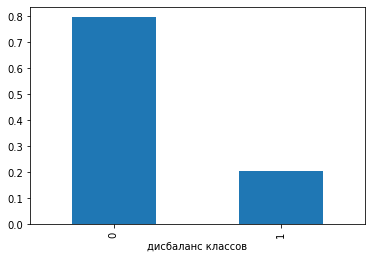

In [20]:
class_frequency = data['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar', xlabel='дисбаланс классов')
plt.show();

Класс с ответом 1 встречается почти в 4 раза реже, это значит что наши модели получились несбалансированными, а мы можем достичь лучших результатов в обучении.

**Резюме**<br/>
С учетом имеющегося дисбаланса классов у нас получились следующие результаты:<br/>
Лучшие значения характеристики f1 у случайного леса 0.548 при auc_roc = 0.844, при достаточно низком значении полноты в 0.428.<br/>
Худшие значения f1 метрики и auc_roc у лотистической регрессии, всего 0.275 и 0.739 соответтсвенно.<br/>

Все значения метрики f1 получились меньше необходимого по условию задачи в 0.59. Но мы знаем о дисбалансе классов, поэтому дальше будем пробовать улучшать качество модели.

## Борьба с дисбалансом

Мы владеем тремя техниками борьбы с дисбалансом:<br/>
- взвешивание классов
- увеличение выборки
- уменьшение выборки

Для первого способа я предусмотрел передачу параметра class_weight со значением "balanced" в фукнцию анализа.<br/>
Для двух последних способов нужно определить 2 функции: для увеличения и для уменьшени выборки соответственно.

In [21]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
print(features_train.shape)
print(features_upsampled.shape)

(6000, 11)
(9588, 11)


Сохранили увеличенную выборку в features_upsampled и target_upsampled. Видно, что количество строк увеличилось.

In [22]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
print(features_train.shape)
print(features_downsampled.shape)

(6000, 11)
(2397, 11)


Сохранили уменьшенную выборку в features_downsampled и target_downsampled. Видно, что количество строк уменьшилось.

Теперь проанализируем все техники и объединим результаты в единую таблицу для анализа.

In [23]:
result_df = class_imbalance \
    + analisys('2. Взвешивание классов', features_train, target_train, features_valid, target_valid, 'balanced') \
    + analisys('3. Увеличение выборки', features_upsampled, target_upsampled, features_valid, target_valid) \
    + analisys('4. Уменьшение выборки', features_downsampled, target_downsampled, features_valid, target_valid)

make_table(result_df)

**Резюме**<br/>
Мне удалось достичь необходимого значения параметра f1: 0.63 больше требуемых 0.59.<br/>
Лучшее значение получается на модели случайного леса при методе борьбы с дисбалансом взвешиванием классов.<br/>
При этом AUC ROC на этой модели также является самым высоким - 0.861.<br/>
Это очень удобно, т.к. метод взвешивания классов уже встроен в качестве параметра конструктора модели в самой библиотеке.<br/>
На самом деле случайный лес достигает параметра 0.59 в каждом способе борьбы с дисбалансом классов.
<br/><br/>
Мы также видим, что метод увеличения выборки очень близок к технике взвешивания классов. Значения f1 и AUC ROC расходятся на несколько тысячных долей. При этом техника уменьшения выборки показывает себя хуже других техник борьбы с дисбалансом.
<br/><br/>
Модель случайного леса показала результаты лучше, чем у логистической регрессии и решающего дерева на всех выборках.

## Тестирование модели

Берем из сводной таблицы параметры для лучшей модели случайного леса обученного с помощью техники взвешивания классов для борьбы с дисбалансом:
{'n_estimators': 70, 'max_depth': 13, 'criterion': 'entropy', 'min_samples_leaf': 5}

Теперь подставим эти параметры для тестовой выборки.

In [24]:
model = RandomForestClassifier(class_weight='balanced', n_estimators=70, max_depth=13, criterion='entropy', min_samples_leaf=5, random_state=12345)
model_characteristics = model_analysis(model, features_train, target_train, features_test, target_test)
pd.DataFrame(data=[model_characteristics])

,Полнота,Точность,F1 метрика,AUC ROC
0,0.643541,0.611364,0.62704,0.856813


На тестовой выборке значение F1 близко к значению, полученному на валидационной выборке: меньше всего на 0.03, а AUC ROC меньше всего на 0.004.
Считаем, что решение найдено.

In [25]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
f1_score(dummy_model.predict(features_test), target_test)

0.3457402812241522

На константной модели значение F1 слишком мало. Можно считать нашу модель адеквктной.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*

# Вывод

Я подготовил исходную выборку для анализа:
- заполнил null в колонке Tenure медианным значением признака, чтобы увеличить объем выборки для исследования
- убрал из датасета признаки, непригодные для анализа: 'RowNumber', 'CustomerId', 'Surname'
- преобразовал категориальные признаки в численные методом прямого кодирования
- привел все признаки к одному масштабу
- разлелил выборку на 3 набора: обучающий, валидационный и тестовый

После чего определил ряд служебных функций для упрощения анализа.

Исследовав целевые признаки я обнаружил дисбаланс классов 1:4, на котором не удается достичь требуемых значений метрики f1.
Максимальное значение удалось рассчитать для случайного леса 0.548. 
Это оказалось меньше требуемых требуемых 0.59.

Поэтому я стал применять известные мне способы борьбы с дисбалансом классов:
- взвешивание классов
- увеличение выборки
- уменьшение выборки

Для увеличения и уменьшения выборки нет готовых функций, поэтому пришлось написать две функции соответственно upsample и downsample.


Для каждого их способов борьбы с дисбалансом исследовал по три модели: логистическая регрессия, решающее дерево, случайный лес.
Случайный лес показал себя лучше на всех выборках: в каждом способе борьбы с дисбалансом классов удалось достичь значения f1 больше требуемых 0.59.

Лучших показателей удалось достичь методом борьбы с дисбалансом классов путем взвешивания классов.

Параметры подходящего случайного леса: 'n_estimators': 70, 'max_depth': 13, 'criterion': 'entropy', 'min_samples_leaf': 5

В этом случае удалось добится показателя f1 = 0.63 c AUC ROC = 0.861.
Эти показатели удовлетворяют условиям поставленной задачи для исследования: добиться показателя больше 0.59.

Тестирование модели случайного леса подтвердило полученные результаты, f1 оказался близок к валидационному = 0.627.
Модель прошла проверку на адекватность.
Решение найдено.